In [1]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import json

In [2]:
# Geometries

geom1 = shapely.wkt.loads('POLYGON ((1.1 1.2, 1.4 5.1, 5.1 5.3, 3 2, 1.1 1.2))')
geom2 = shapely.wkt.loads('POLYGON ((0 0, 2 3, 2 4, 2 4, 2.1 2.5, 4 2, 2.1 2.1, 0 0))')
geom3 = shapely.wkt.loads('POLYGON ((-24.3 10.48, -19.32 12.44, -15.3 14.2, -15.3 13.78, -15.3 13.9, -15.06 10.4, -17.44 11.38, -19.18 11.46, -14.82 9.08, -12.9 10.14, -12.08 7.86, -14.36 5.94, -15.92 8.34, -16.86 3.48, -19.38 4.4, -18.2 6.52, -20.08 7.4, -24.34 6.68, -24.24 8.66, -27.52 11.1,  -27.0 11.1, -24.3 10.48))')
geom4 = shapely.wkt.loads('POLYGON ((-9.9 16.85, -5.95 17.67, -6.19 13.49, -9.81 12.74, -7.35 9.2, -6.82 6.19, -10 6, -12.36 5.75, -14.59 8.1, -12 10, -13.93 12.31, -17.35 12.45, -16.83 15.6, -20.45 14.6, -22.36 12, -22 9.37, -27.1 6.48, -30 11.7, -27.9 15.5, -21.46 17.26, -19.6 16.1, -14.77 17.6, -11.43 13.32, -9.9 16.85))')

def parse_intersection_data(file_name, max_shps=999999999):
    geom_pairs = []
    geom_stats = []
    if file_name.endswith('.json'):
        with open(f'data/intersection/{file_name}','r') as file:
            data = json.loads(file.read())
        for i in range(0, min(len(data), max_shps * 4), 4): # Don't include a new line in end of file
            type = data[i]
            p1 = shapely.from_wkt(data[i + 1])
            p2 = shapely.from_wkt(data[i + 2])
            intersects = data[i + 3]
            geom_pairs.append((p1, p2))
            geom_stats.append((type, intersects))
    else:
        file = open(f'data/intersection/{file_name}', 'r')

        lines = file.read().splitlines()
        for i in range(0, min(len(lines), max_shps), 3): # Don't include a new line in end of file
            p1 = shapely.from_wkt(lines[i])
            p2 = shapely.from_wkt(lines[i + 1])
            geom_pairs.append((p1, p2))
    return geom_pairs, geom_stats

manual_data, _ = parse_intersection_data("manual")
#world_data, world_data_stats = parse_intersection_data("world.json", 100)
lund_data, lund_data_stats = parse_intersection_data("lund.json", 100)

In [3]:
SHOW_COORDINATES = False
SHOW_GEOMETRIES = False
SHOW_INTERSECTING_POINTS = False
SHOW_COMMON_BOUNDING_BOX = False
SHOW_BOUNDING_BOXES = False

In [4]:
import intersection.first_bin_search
import intersection.chunk_bbox_intersection
binary_intersection = intersection.first_bin_search.binary_intersection
chunk_bbox_is_intersecting = intersection.chunk_bbox_intersection.is_intersecting

from intersection.plotting import *

from algos.alg_fpd_extended import FpdExtended
fpd = FpdExtended()

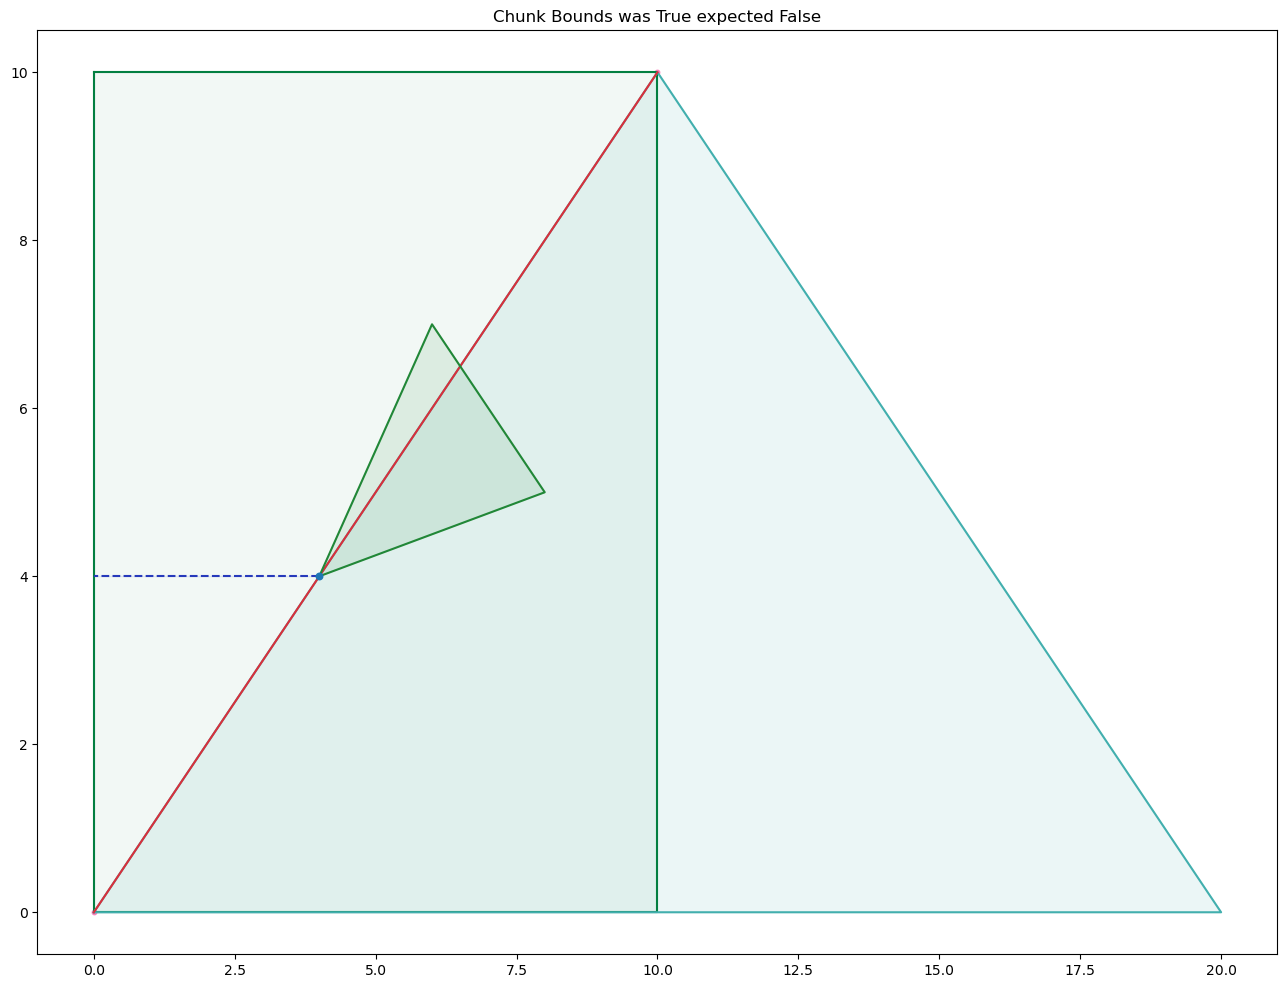

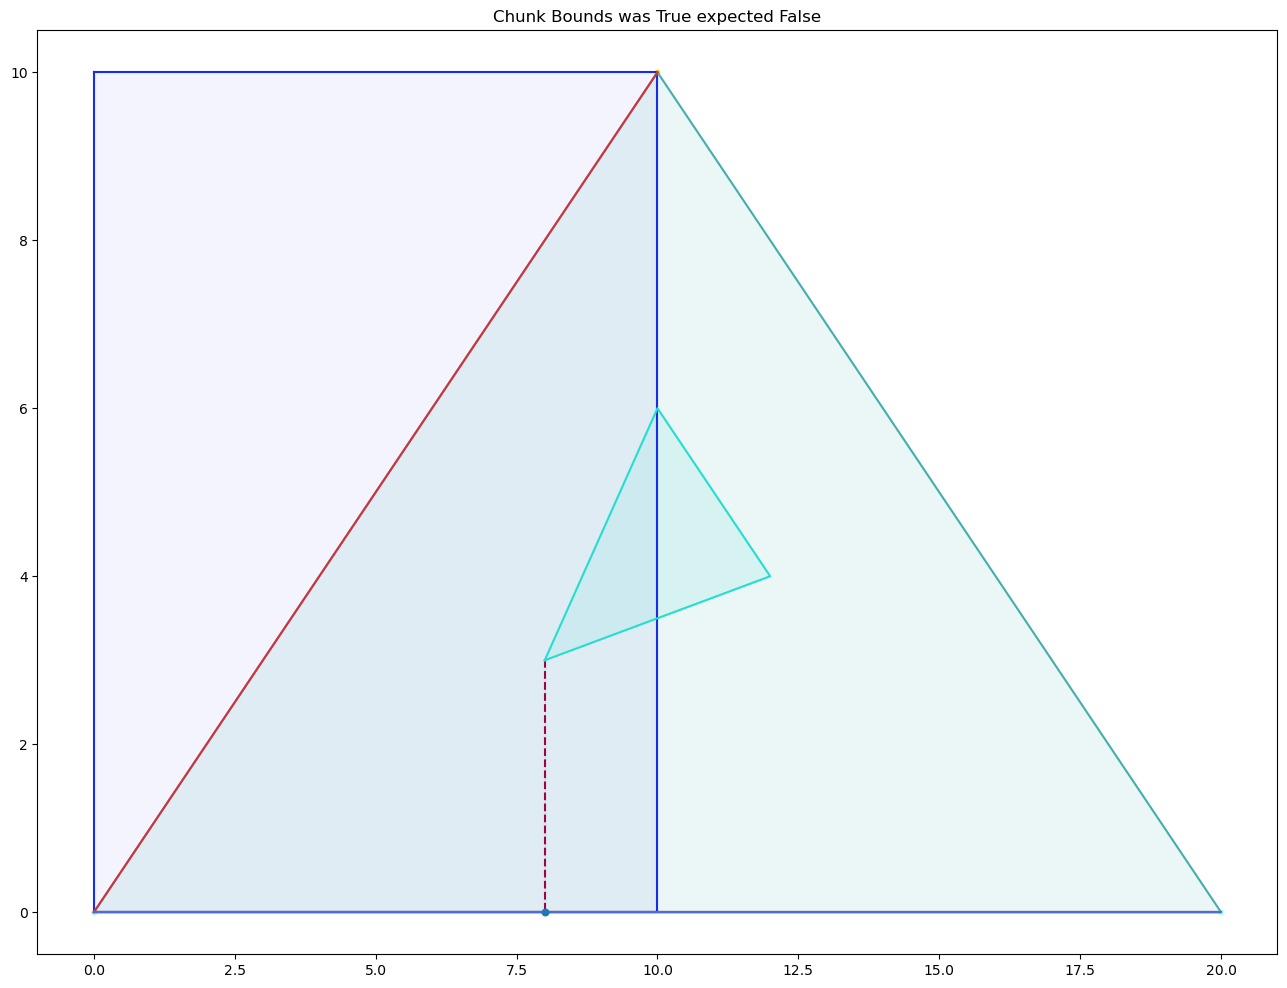

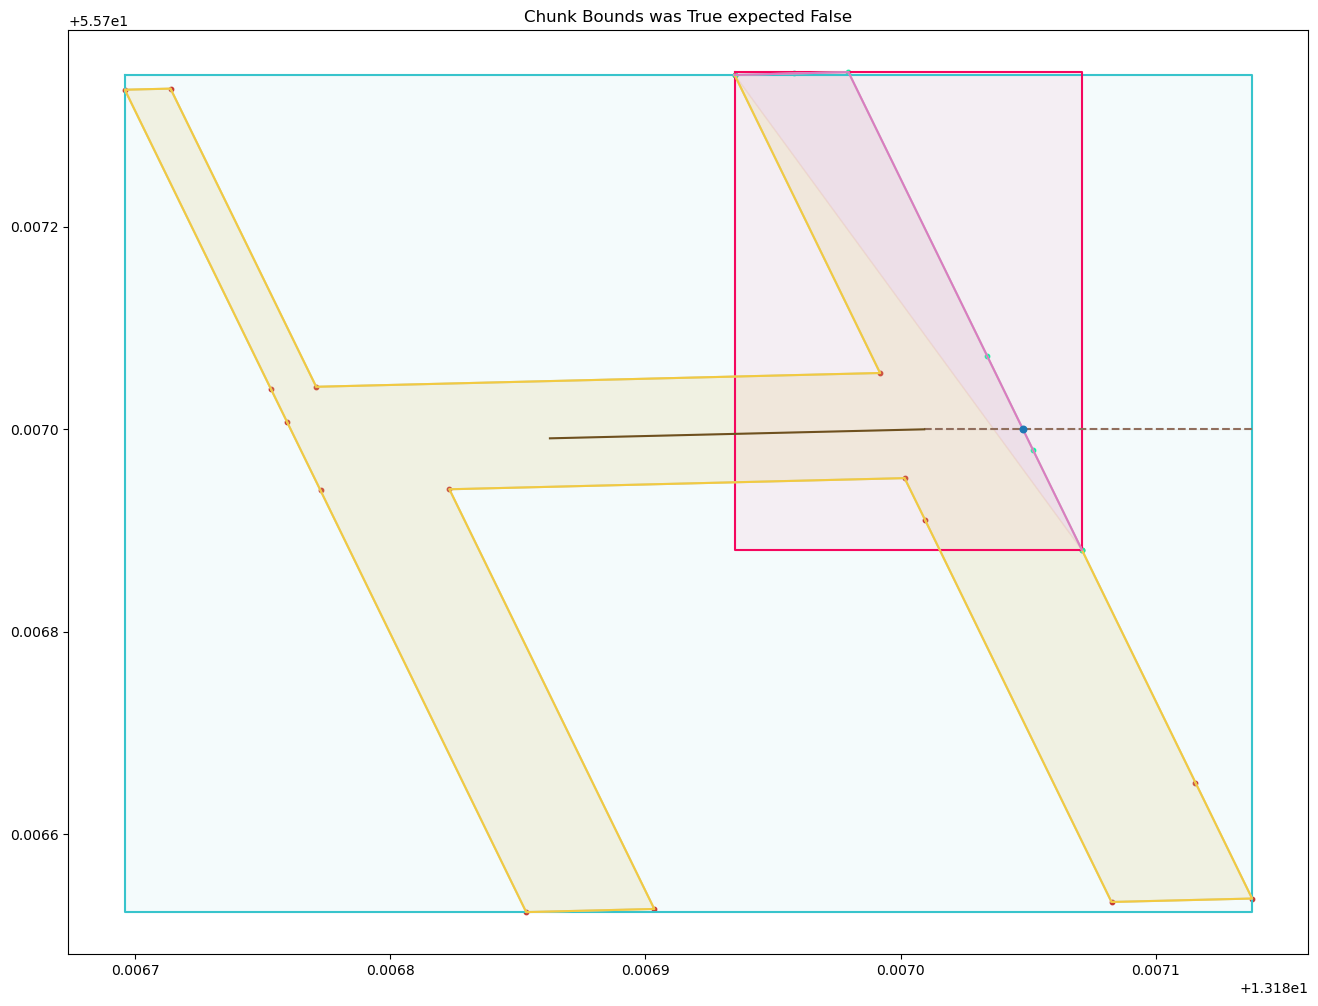

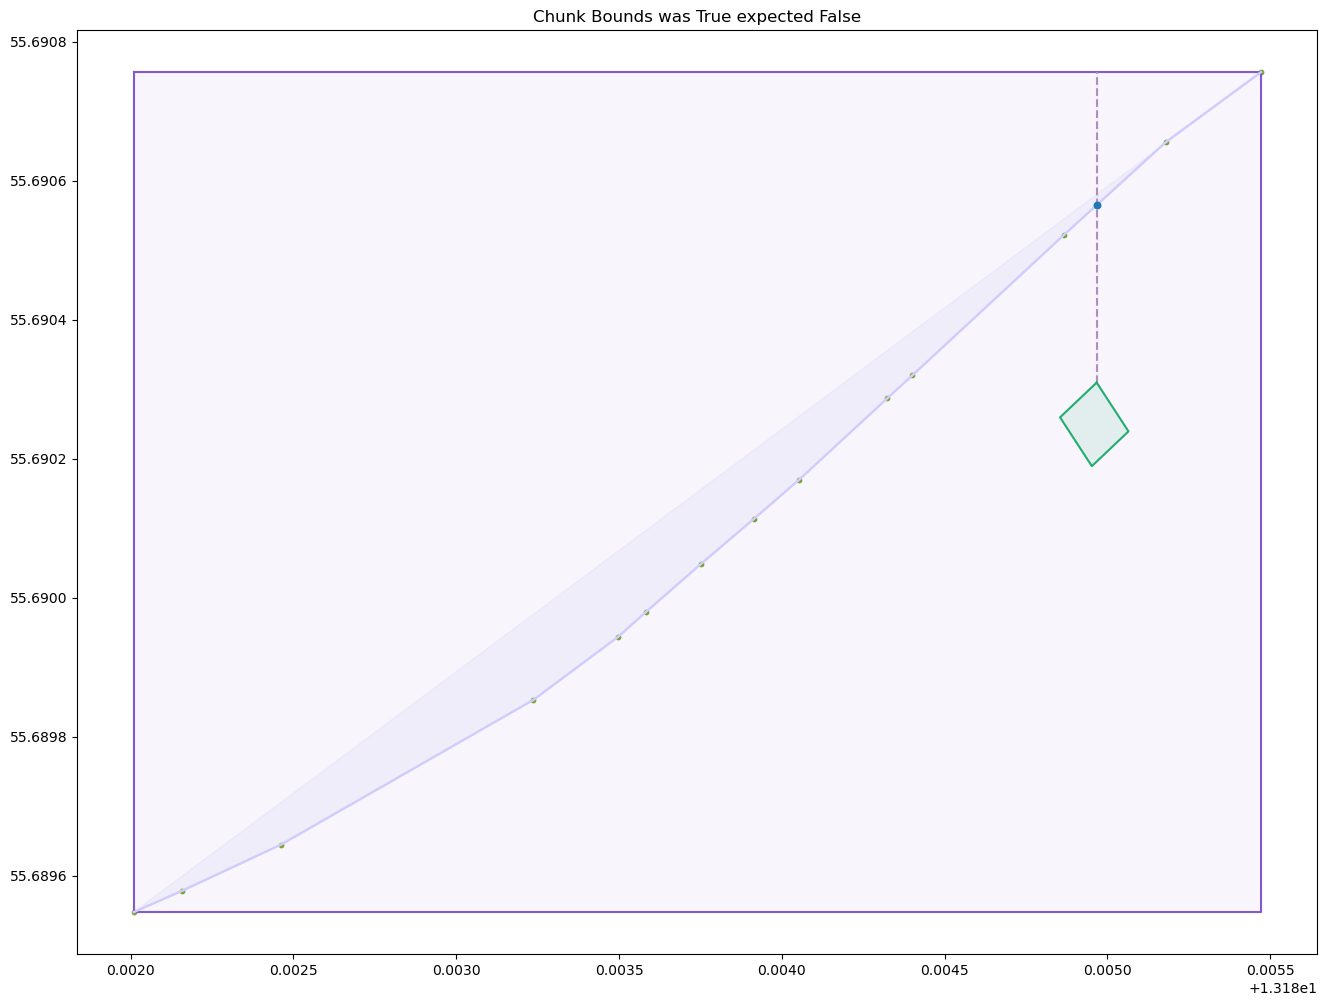

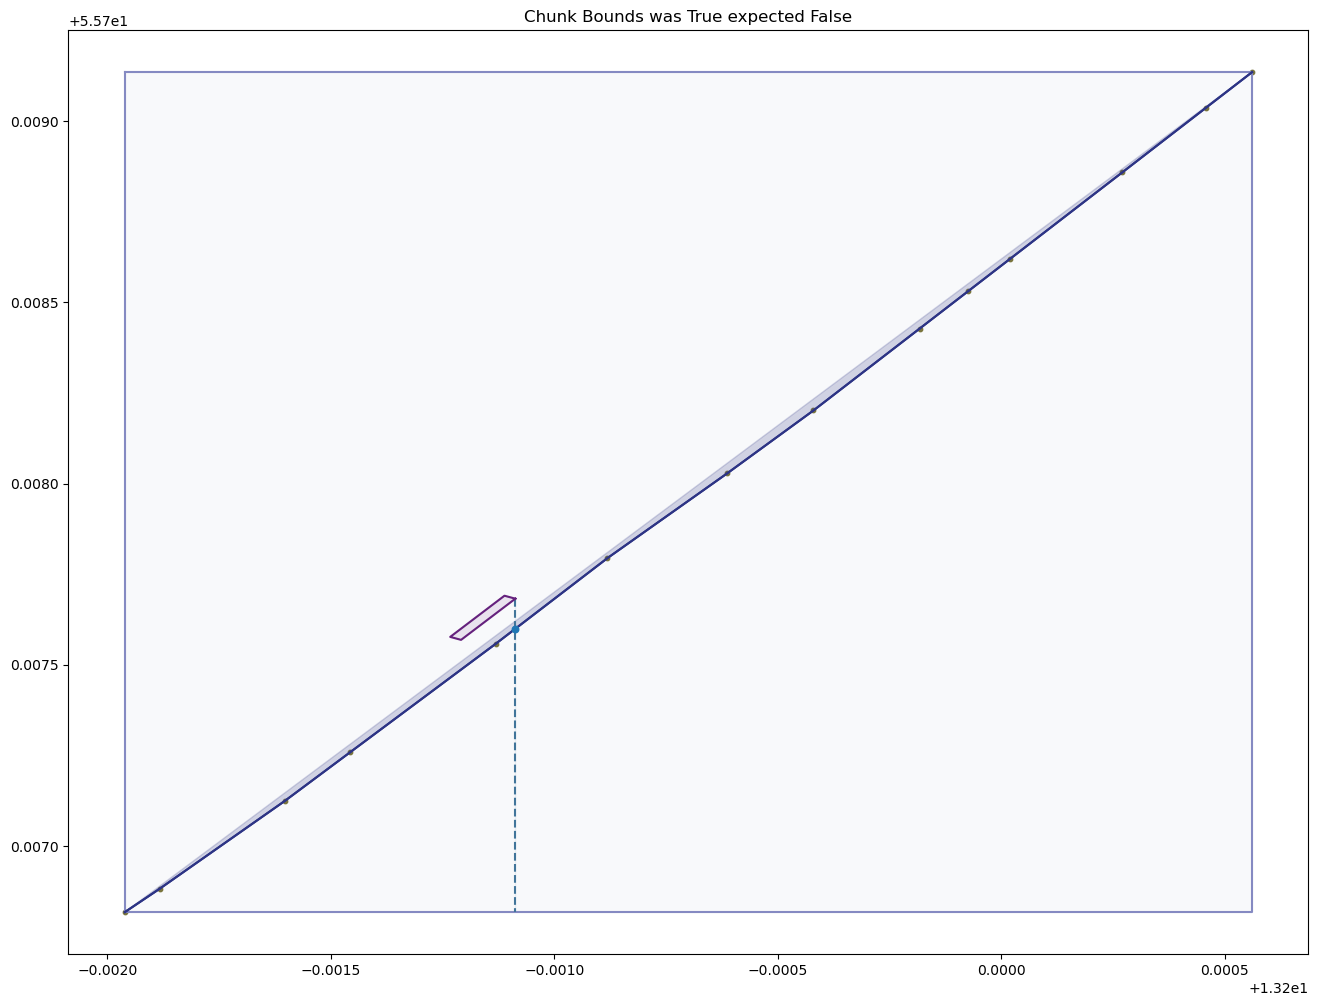

Done. Passed: 96 of 107.


Exception: Failed intersection!

In [5]:
total = 0
passed = 0
def evaluate_dataset(data, plot, total, passed):
    for g1, g2 in data:
        #is_intersecting, intersect_points = binary_intersection(g1, g2)

        _, b1 = fpd.compress(g1)
        _, b2 = fpd.compress(g2)
        exp = shapely.intersects(g1, g2)
        is_intersecting = chunk_bbox_is_intersecting((b1, b2), exp)

        if plot:
            if False: # Plot chunks?
                plot_chunks_bounds(b1, True, avoid_show=True)
                plot_chunks_bounds(b2, True, avoid_create_frame=True)
                
            geoms = (g1, g2)
            for g in geoms:
                plot_geometry(g, SHOW_GEOMETRIES)
                plot_geometry_bbox(g, SHOW_BOUNDING_BOXES)
                plot_coordinates(g, SHOW_COORDINATES)
            
            plot_common_bbox(geoms, SHOW_COMMON_BOUNDING_BOX)
            #plot_intersecting_points(intersect_points, legends, SHOW_INTERSECTING_POINTS)

            if SHOW_COORDINATES or SHOW_GEOMETRIES or SHOW_INTERSECTING_POINTS or SHOW_COMMON_BOUNDING_BOX or SHOW_BOUNDING_BOXES:
                plt.title("Intersection Plot: " + ('True' if is_intersecting else 'False'))
                plt.show()
            if is_intersecting != exp:
                print("Above FAILED!")
            else:
                print("Passed!")
                
        total += 1
        if is_intersecting == exp:
            passed += 1
    return total, passed

total, passed = evaluate_dataset(manual_data, False, total, passed)
#total, passed = evaluate_dataset(world_data[1:5], True, total, passed)
total, passed = evaluate_dataset(lund_data, False, total, passed)

print(f'Done. Passed: {passed} of {total}.')
if passed != total:
    raise(Exception("Failed intersection!"))